<a href="https://colab.research.google.com/github/LuisFernandoCampos/modelo_cliente_fuga/blob/main/modelo_cliente_fuga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [353]:
!pip install session_info

In [354]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import session_info
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [355]:
cliente=pd.read_csv("/content/client_data.csv")
precio=pd.read_csv("/content/price_data.csv")

# 1.- EDA y Preprocesamiento

In [356]:
cliente.shape

(14606, 26)

In [357]:
cliente.id.value_counts().sort_values(ascending=False)

24011ae4ebbe3035111d65fa7c15bc57    1
26c7bba7d51f86a16109de505bcd4f52    1
74ff037708f036de5745ce34d8d9d4df    1
21860c2ff2d5df75503b230ce629c253    1
764c75f661154dac3a6c254cd082ea7d    1
                                   ..
46362cb1ad2fcdad347a6fa1bc1e5d4b    1
c49217f16a06263e5381eaba94a67a8b    1
18463073fb097fc0ac5d3e040f356987    1
d0a6f71671571ed83b2645d23af6de00    1
563dde550fd624d7352f3de77c0cdfcd    1
Name: id, Length: 14606, dtype: int64

La tabla **cliente** contiene identificadores de clientes unicos

In [358]:
precio.shape

(193002, 8)

In [359]:
precio.id.value_counts().sort_values(ascending=False)

038af19179925da21a25619c5a24b745    12
352fa0ef0fdb3c21328ef497c78ffa06    12
a020b85d573fa4fb1c2d11f972fe57e4    12
f83c1ab1ca1d1802bb1df4d72820243c    12
18a2e2110c48a41ff98cc799b0f016c4    12
                                    ..
83cf18b07114e495ae8b7fb235e45ee2     8
3e459d61dc831e29f8a9a9a59f95efd2     8
c5dcd5c506e565aaabffa29bc1ec0a37     7
bf89f2d8c1b133a134fd93603cb4c947     7
15b36e47cf04bf151e3f4438d12672e5     7
Name: id, Length: 16096, dtype: int64

La tabla **precio** no contiene identificadores unicos

In [360]:
precio.head(2)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [361]:
precio.describe().T

,count,mean,std,min,25%,50%,75%,max
price_off_peak_var,193002.0,0.141027,0.025032,0.0,0.125976,0.146033,0.151635,0.280700
price_peak_var,193002.0,0.054630,0.049924,0.0,0.000000,0.085483,0.101673,0.229788
price_mid_peak_var,193002.0,0.030496,0.036298,0.0,0.000000,0.000000,0.072558,0.114102
price_off_peak_fix,193002.0,43.334477,5.410297,0.0,40.728885,44.266930,44.444710,59.444710
price_peak_fix,193002.0,10.622875,12.841895,0.0,0.000000,0.000000,24.339581,36.490692
price_mid_peak_fix,193002.0,6.409984,7.773592,0.0,0.000000,0.000000,16.226389,17.458221


 ## Nosotros intentamos validar la hipotesis de que la rotacion es impulsada por el precio, por ello trabajaremos en un primer momento con la tabla precio.

In [362]:
# Cambiamos el tipo de dato de la variable "price_date"
precio['price_date'] = pd.to_datetime(precio['price_date'], format='%Y-%m-%d')

## 1ra forma: Ingenieria de Caracteristicas

In [363]:
precio.head(2)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [364]:
# Hallamos los promedios de los precios en periodos de un año, 6 meses y 3 meses, esto con la finalidad de obterner variedad
mean_year = precio.groupby(["id"]).mean().reset_index()
mean_6m = precio[precio["price_date"] > "2015-06-01"].groupby("id").mean().reset_index()
mean_3m = precio[precio["price_date"] > "2015-10-01"].groupby("id").mean().reset_index()

In [365]:
mean_year.head(1)

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694


In [366]:
mean_6m.head(1)

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.121266,0.102368,0.073728,40.728885,24.43733,16.291555


In [367]:
mean_3m.head(1)

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555


### Mean_year

In [368]:
# Cambiamos el nombre de nuestras columnas
mean_year = mean_year.rename(
    columns={
        "price_off_peak_var": "mean_year_price_off_peak_var",
        "price_peak_var": "mean_year_price_peak_var",
        "price_mid_peak_var": "mean_year_price_mid_peak_var",
        "price_off_peak_fix": "mean_year_price_off_peak_fix",
        "price_peak_fix": "mean_year_price_peak_fix",
        "price_mid_peak_fix": "mean_year_price_mid_peak_fix"
    }
)

# Combinamos nuestras columnas
mean_year["mean_year_price_off_peak"] = mean_year["mean_year_price_off_peak_var"] + mean_year["mean_year_price_off_peak_fix"]
mean_year["mean_year_price_peak"] = mean_year["mean_year_price_peak_var"] + mean_year["mean_year_price_peak_fix"]
mean_year["mean_year_price_mid_peak"] = mean_year["mean_year_price_mid_peak_var"] + mean_year["mean_year_price_mid_peak_fix"]

### Mean_6m

In [369]:
# Cambiamos el nombre de nuestras columnas
mean_6m = mean_6m.rename(
    columns={
        "price_off_peak_var": "mean_6m_price_off_peak_var",
        "price_peak_var": "mean_6m_price_peak_var",
        "price_mid_peak_var": "mean_6m_price_mid_peak_var",
        "price_off_peak_fix": "mean_6m_price_off_peak_fix",
        "price_peak_fix": "mean_6m_price_peak_fix",
        "price_mid_peak_fix": "mean_6m_price_mid_peak_fix"
    }
)

# Combinamos nuestras columnas
mean_6m["mean_6m_price_off_peak"] = mean_6m["mean_6m_price_off_peak_var"] + mean_6m["mean_6m_price_off_peak_fix"]
mean_6m["mean_6m_price_peak"] = mean_6m["mean_6m_price_peak_var"] + mean_6m["mean_6m_price_peak_fix"]
mean_6m["mean_6m_price_mid_peak"] = mean_6m["mean_6m_price_mid_peak_var"] + mean_6m["mean_6m_price_mid_peak_fix"]

### Mean_3m

In [370]:
# Cambiamos el nombre de nuestras columnas
mean_3m = mean_3m.rename(
    columns={
        "price_off_peak_var": "mean_3m_price_off_peak_var",
        "price_peak_var": "mean_3m_price_peak_var",
        "price_mid_peak_var": "mean_3m_price_mid_peak_var",
        "price_off_peak_fix": "mean_3m_price_off_peak_fix",
        "price_peak_fix": "mean_3m_price_peak_fix",
        "price_mid_peak_fix": "mean_3m_price_mid_peak_fix"
    }
)

# Combinamos nuestras columnas
mean_3m["mean_3m_price_off_peak"] = mean_3m["mean_3m_price_off_peak_var"] + mean_3m["mean_3m_price_off_peak_fix"]
mean_3m["mean_3m_price_peak"] = mean_3m["mean_3m_price_peak_var"] + mean_3m["mean_3m_price_peak_fix"]
mean_3m["mean_3m_price_mid_peak"] = mean_3m["mean_3m_price_mid_peak_var"] + mean_3m["mean_3m_price_mid_peak_fix"]

### Fusionamos tablas y analizamos

In [371]:
# Fusionamos nuestras tablas: mean_year, mean_6m y mean_3m
precio_year_6m=mean_year.merge(mean_6m)
precio_year_6m_3m=precio_year_6m.merge(mean_3m)

In [372]:
precio_year_6m_3m.head(1)

,id,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_mid_peak,...,mean_6m_price_mid_peak,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,...,16.365283,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555,40.848791,24.539003,16.365274


In [373]:
precio_year_6m_3m.shape

(16095, 28)

In [374]:
# Fusianamos la tabla resultante con los datos de abandono y veamos si el precio tiene alguna corelacion con el abandono
precio_analisis1=precio_year_6m_3m.merge(cliente[["id","churn"]])
precio_analisis1.head(1)

,id,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_mid_peak,...,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,churn
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,...,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555,40.848791,24.539003,16.365274,0


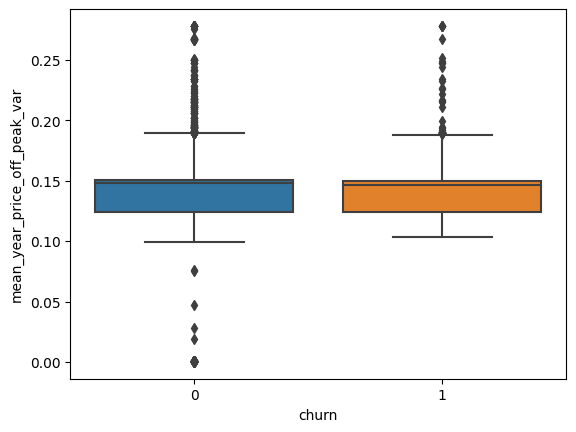

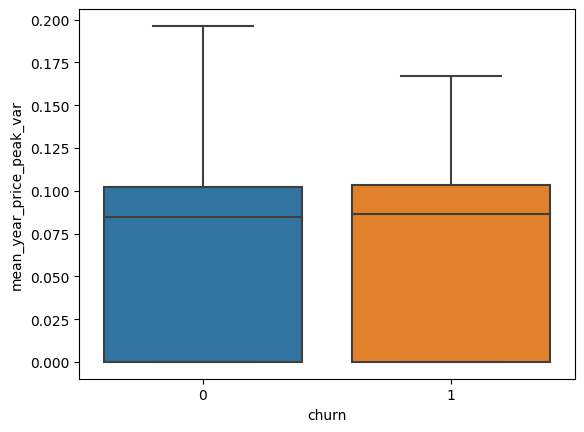

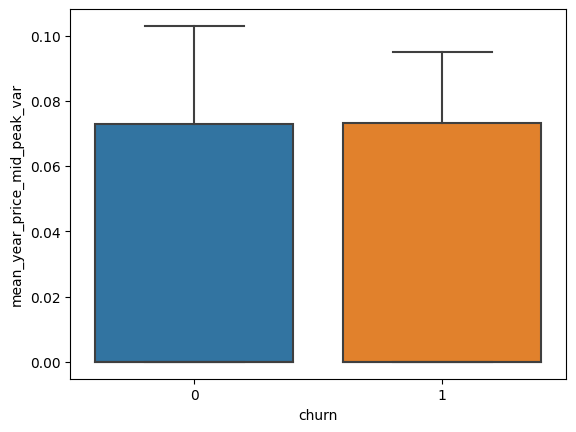

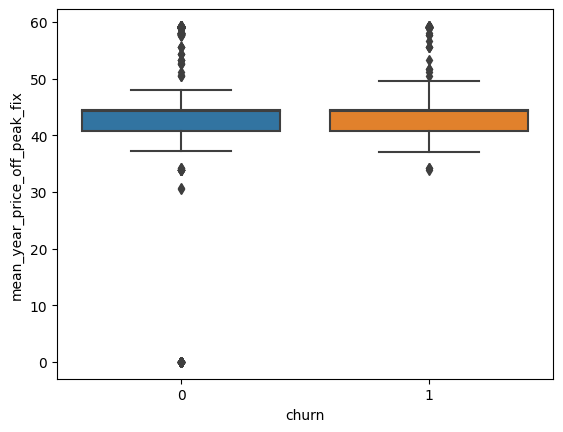

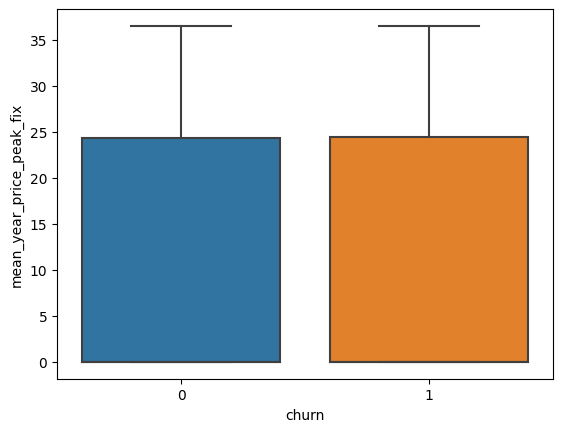

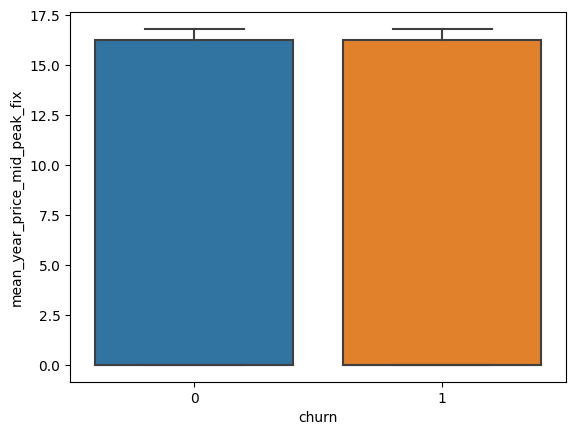

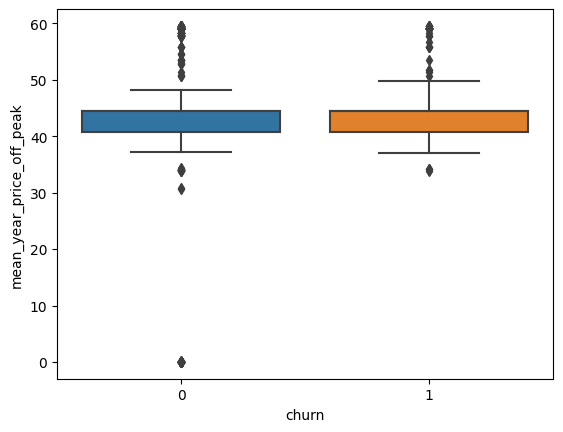

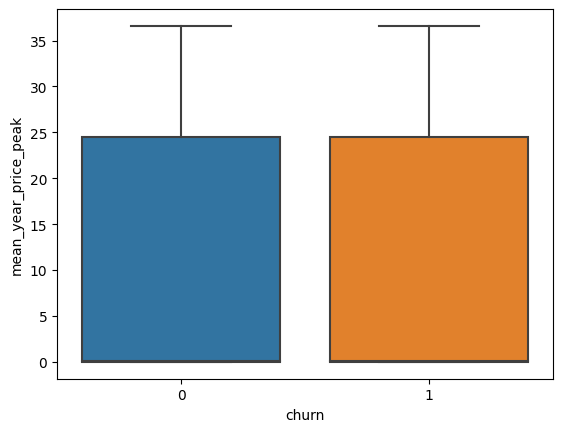

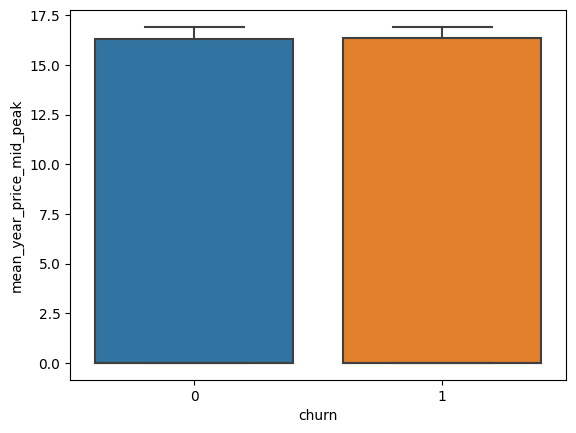

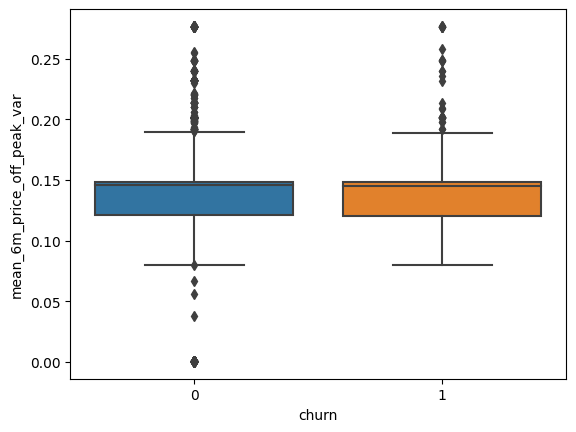

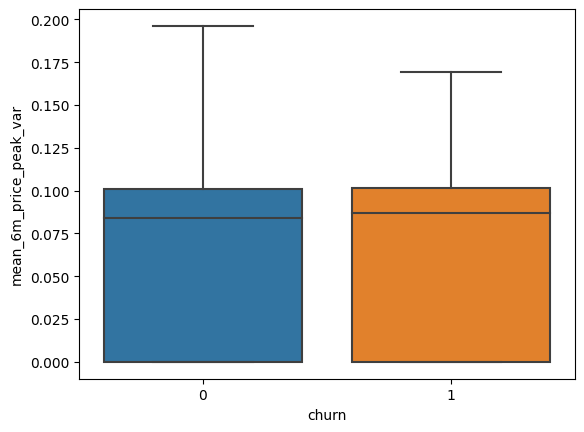

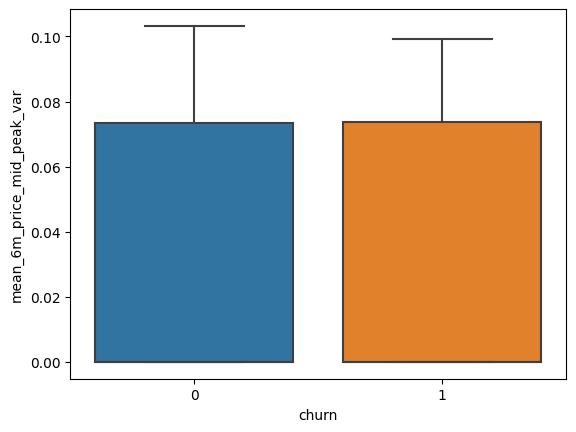

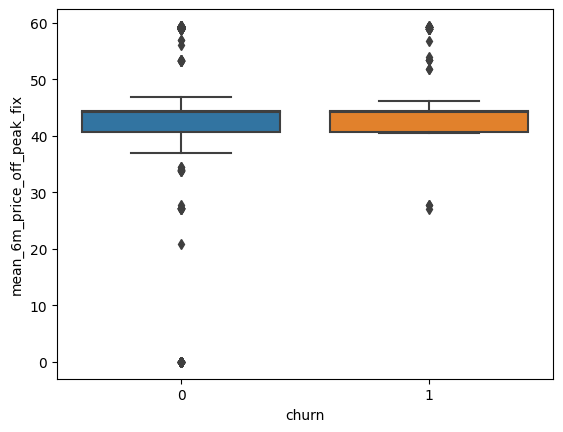

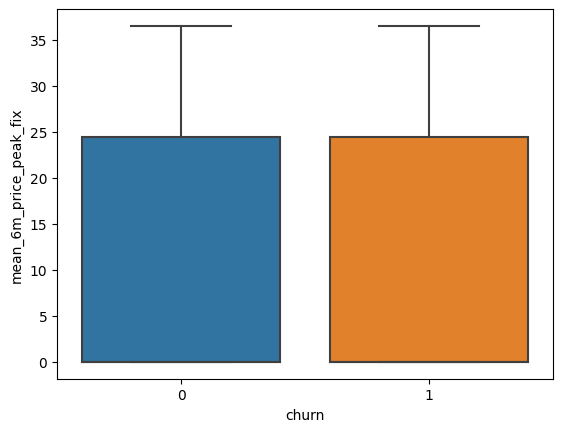

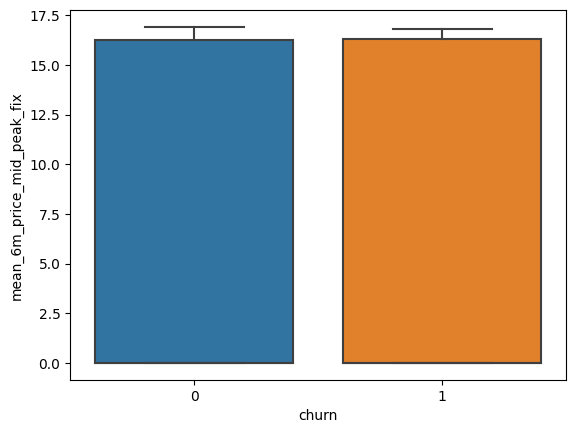

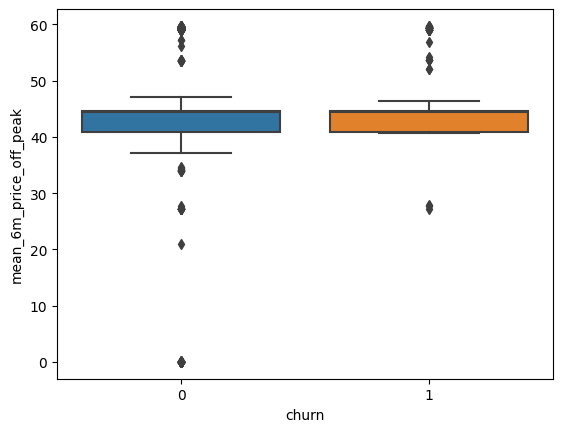

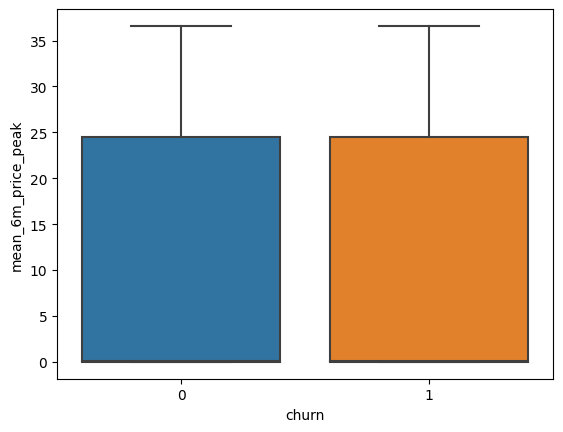

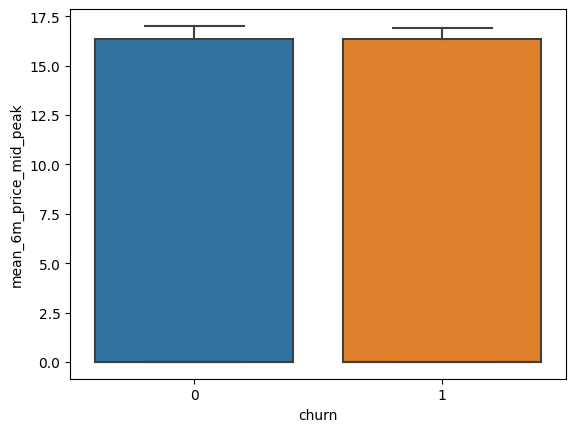

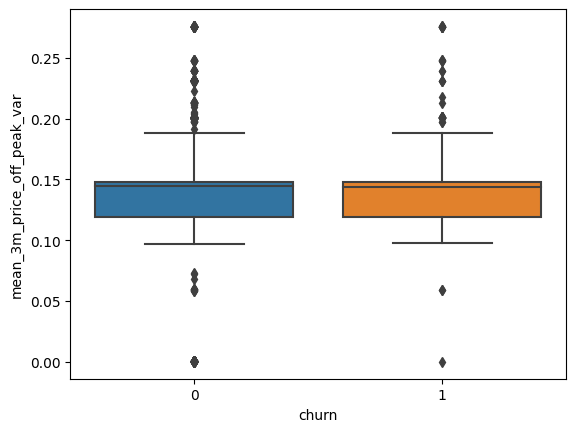

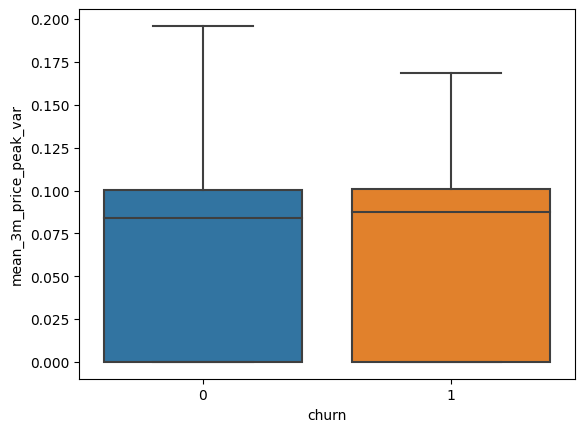

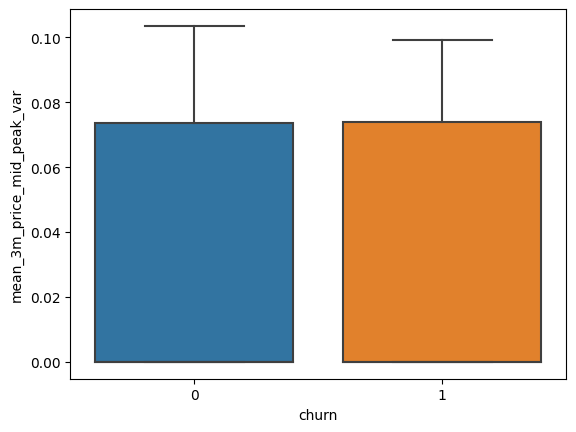

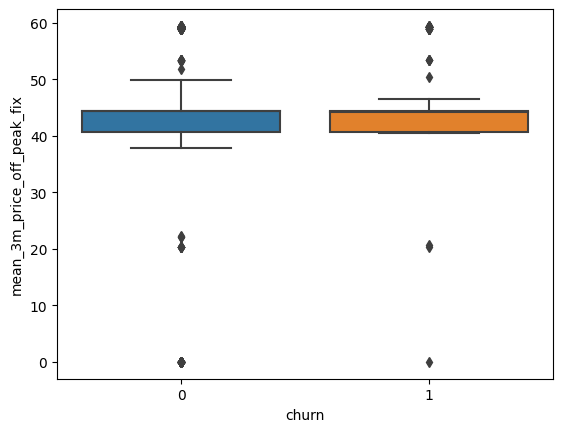

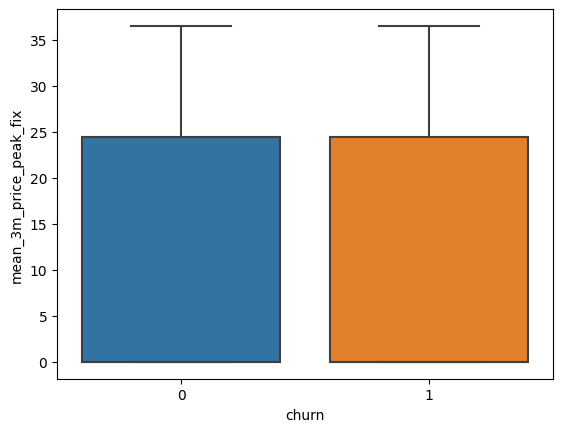

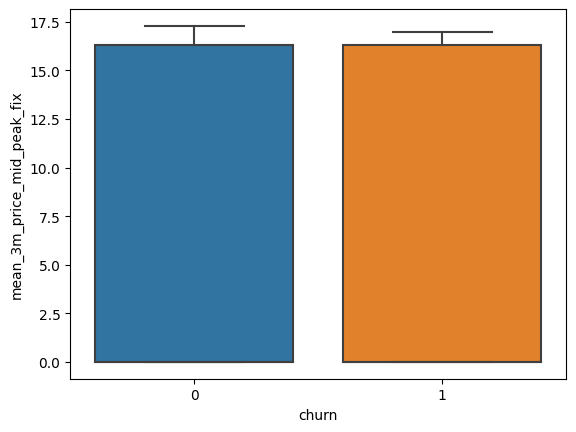

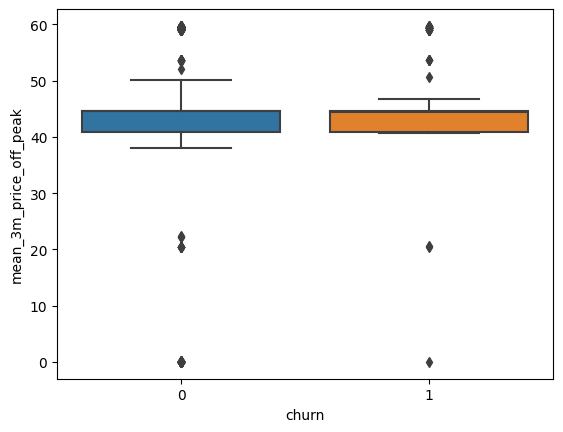

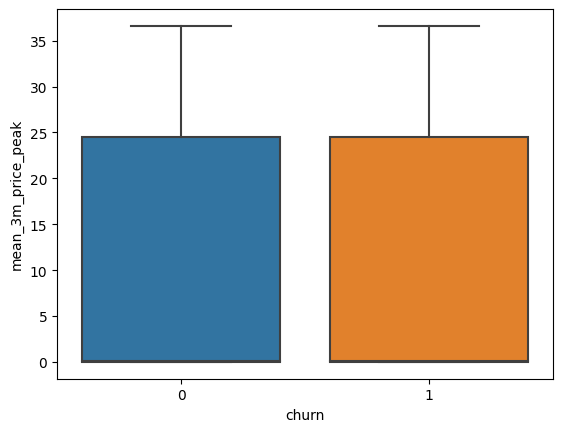

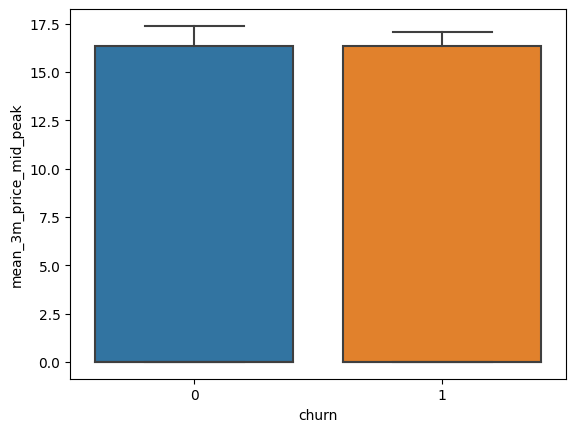

In [375]:
for col in precio_analisis1.drop(["id","churn"], axis=1).columns:
  sns.boxplot(x=precio_analisis1["churn"],y=precio_analisis1[col])
  plt.show()

In [376]:
precio_analisis1.drop("id",axis=1).corrwith(precio_analisis1["churn"]).sort_values(ascending=False)

churn                           1.000000
mean_year_price_peak_fix        0.047224
mean_year_price_peak            0.047188
mean_6m_price_peak_fix          0.047067
mean_6m_price_peak              0.047030
mean_year_price_mid_peak_var    0.046528
mean_6m_price_mid_peak_var      0.046225
mean_3m_price_peak_fix          0.045755
mean_3m_price_peak              0.045724
mean_3m_price_mid_peak_var      0.045218
mean_year_price_mid_peak        0.044835
mean_year_price_mid_peak_fix    0.044825
mean_6m_price_mid_peak          0.044771
mean_6m_price_mid_peak_fix      0.044763
mean_3m_price_mid_peak          0.043543
mean_3m_price_mid_peak_fix      0.043534
mean_year_price_peak_var        0.029604
mean_6m_price_peak_var          0.028895
mean_3m_price_peak_var          0.028812
mean_6m_price_off_peak_fix      0.016906
mean_6m_price_off_peak          0.016811
mean_year_price_off_peak_fix    0.016807
mean_year_price_off_peak        0.016720
mean_3m_price_off_peak_fix      0.015278
mean_3m_price_of

La correlacion con respecto a la variable **churn** es bastante baja

## 2da forma: Ingenieria de Caracteristicas

In [377]:
precio.head(2)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [378]:
# Agrupamos por "id" y "price_date" y promediamos
precio_group= precio.groupby(['id', 'price_date']).mean().reset_index()
precio_group.head(2)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389


In [379]:
# Agrupamos por "id" y jalamos solo el precio de enero
ene=precio_group.groupby('id').first().reset_index()
# Renonbramos el nombre de las columas
ene = ene.rename(
    columns={
        "price_off_peak_var": "ene_off_var",
        "price_peak_var": "ene_var",
        "price_mid_peak_var": "ene_mid_var",
        "price_off_peak_fix": "ene_off_fix",
        "price_peak_fix": "ene_fix",
        "price_mid_peak_fix": "ene_mid_fix"
    }
)

# Agrupamos por "id" y jalamos solo el precio de diciembre
dic=precio_group.groupby('id').last().reset_index()
# Renonbramos el nombre de las columnas
dic = dic.rename(
    columns={
        "price_off_peak_var": "dic_off_var",
        "price_peak_var": "dic_var",
        "price_mid_peak_var": "dic_mid_var",
        "price_off_peak_fix": "dic_off_fix",
        "price_peak_fix": "dic_fix",
        "price_mid_peak_fix": "dic_mid_fix"
    }
)

In [380]:
ene.head(1)

,id,price_date,ene_off_var,ene_var,ene_mid_var,ene_off_fix,ene_fix,ene_mid_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389


In [381]:
dic.head(1)

,id,price_date,dic_off_var,dic_var,dic_mid_var,dic_off_fix,dic_fix,dic_mid_fix
0,0002203ffbb812588b632b9e628cc38d,2015-12-01,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555


In [382]:
# Fusionamos nuestras tablas
ene_dic=ene.merge(dic.drop("price_date",axis=1))
ene_dic.head(1)

,id,price_date,ene_off_var,ene_var,ene_mid_var,ene_off_fix,ene_fix,ene_mid_fix,dic_off_var,dic_var,dic_mid_var,dic_off_fix,dic_fix,dic_mid_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555


In [383]:
# Creamos nuevas variables
ene_dic["dic_ene_off_var"]=ene_dic["dic_off_var"]-ene_dic["ene_off_var"]
ene_dic["dic_ene_var"]=ene_dic["dic_var"]-ene_dic["ene_var"]
ene_dic["dic_ene_mid_var"]=ene_dic["dic_mid_var"]-ene_dic["ene_mid_var"]
ene_dic["dic_ene_off_fix"]=ene_dic["dic_off_fix"]-ene_dic["ene_off_fix"]
ene_dic["dic_ene_fix"]=ene_dic["dic_fix"]-ene_dic["ene_fix"]
ene_dic["dic_ene_mid_fix"]=ene_dic["dic_mid_fix"]-ene_dic["ene_mid_fix"]

In [384]:
# Seleccionamos solo las nuevas variables
ene_dic=ene_dic[["id","dic_ene_off_var","dic_ene_var","dic_ene_mid_var","dic_ene_off_fix","dic_ene_fix","dic_ene_mid_fix"]]
ene_dic.head(1)

,id,dic_ene_off_var,dic_ene_var,dic_ene_mid_var,dic_ene_off_fix,dic_ene_fix,dic_ene_mid_fix
0,0002203ffbb812588b632b9e628cc38d,-0.006192,-0.002302,0.003487,0.162916,0.097749,0.065166


In [385]:
# Fusianamos la tabla resultante con los datos de abandono y veamos si el precio tiene alguna corelacion con el abandono
precio_analisis2=ene_dic.merge(cliente[["id","churn"]])
precio_analisis2.head(1)

,id,dic_ene_off_var,dic_ene_var,dic_ene_mid_var,dic_ene_off_fix,dic_ene_fix,dic_ene_mid_fix,churn
0,0002203ffbb812588b632b9e628cc38d,-0.006192,-0.002302,0.003487,0.162916,0.097749,0.065166,0


In [386]:
precio_analisis2.drop("id",axis=1).corrwith(precio_analisis2["churn"]).sort_values(ascending=False)

churn              1.000000
dic_ene_off_fix    0.002672
dic_ene_mid_var    0.000191
dic_ene_off_var   -0.001064
dic_ene_mid_fix   -0.002681
dic_ene_var       -0.004041
dic_ene_fix       -0.005183
dtype: float64

En relacion con el anterior analisis, esta forma entrega una correlacion mucho mas baja aun, casi cercana al **cero**

## Fusionamos los analisis con la tabla cliente

In [387]:
# Fusionamos los dos analisis en una sola tabla
precio_analisis=precio_analisis1.drop("churn", axis=1).merge(precio_analisis2)
precio_analisis.head(1)

,id,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_mid_peak,...,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,dic_ene_off_var,dic_ene_var,dic_ene_mid_var,dic_ene_off_fix,dic_ene_fix,dic_ene_mid_fix,churn
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,...,40.848791,24.539003,16.365274,-0.006192,-0.002302,0.003487,0.162916,0.097749,0.065166,0


In [388]:
# Fusionamos "precio_analisis" con la tabla "cliente"
precio_cliente=precio_analisis.drop("churn", axis=1).merge(cliente)
precio_cliente.head()

,id,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_mid_peak,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,...,f,40.78,43.08,43.08,1,81.42,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,17.250,0
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000,...,f,0.00,24.42,24.42,1,61.58,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000,...,f,213.76,38.58,38.58,2,81.61,3,lxidpiddsbxsbosboudacockeimpuepw,13.856,0
3,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000,...,f,0.00,29.76,29.76,1,157.99,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,0013f326a839a2f6ad87a1859952d227,0.126076,0.105542,0.074921,40.728885,24.437330,16.291555,40.854961,24.542872,16.366476,...,f,195.20,30.00,30.00,1,341.58,3,lxidpiddsbxsbosboudacockeimpuepw,20.000,0


In [389]:
# Veamos las variables categoricas
precio_cliente.select_dtypes(exclude="number").columns

Index(['id', 'channel_sales', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'has_gas', 'origin_up'],
      dtype='object')

# Analizamos variables categoricas

## channel_sales y churn

In [390]:
# Para un mejor entedimiento solo seleccionamos las columnas que se van a utilizar
pc= precio_cliente[['id', 'channel_sales', 'churn']]
# Pivotamos la variable "churn"
channel= pc.groupby(["channel_sales","churn"])['id'].count().unstack(level=1)
# Operamos para obtener los valores en porcentaje
channel_porc= (channel.div(channel.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)

In [391]:
chel= pc.groupby(["channel_sales","churn"])['channel_sales'].count().unstack(level=1)

In [392]:
channel

churn,0,1
channel_sales,,
MISSING,3442.0,283.0
epumfxlbckeskwekxbiuasklxalciiuu,3.0,NaN
ewpakwlliwisiwduibdlfmalxowmwpci,818.0,75.0
fixdbufsefwooaasfcxdxadsiekoceaa,2.0,NaN
foosdfpfkusacimwkcsosbicdxkicaua,5933.0,820.0
lmkebamcaaclubfxadlmueccxoimlema,1740.0,103.0
sddiedcslfslkckwlfkdpoeeailfpeds,11.0,NaN
usilxuppasemubllopkaafesmlibmsdf,1237.0,138.0


In [393]:
channel_porc

churn,0,1
channel_sales,,
foosdfpfkusacimwkcsosbicdxkicaua,87.857249,12.142751
usilxuppasemubllopkaafesmlibmsdf,89.963636,10.036364
ewpakwlliwisiwduibdlfmalxowmwpci,91.601344,8.398656
MISSING,92.402685,7.597315
lmkebamcaaclubfxadlmueccxoimlema,94.411286,5.588714
epumfxlbckeskwekxbiuasklxalciiuu,100.000000,NaN
fixdbufsefwooaasfcxdxadsiekoceaa,100.000000,NaN
sddiedcslfslkckwlfkdpoeeailfpeds,100.000000,NaN


<Axes: xlabel='channel_sales'>

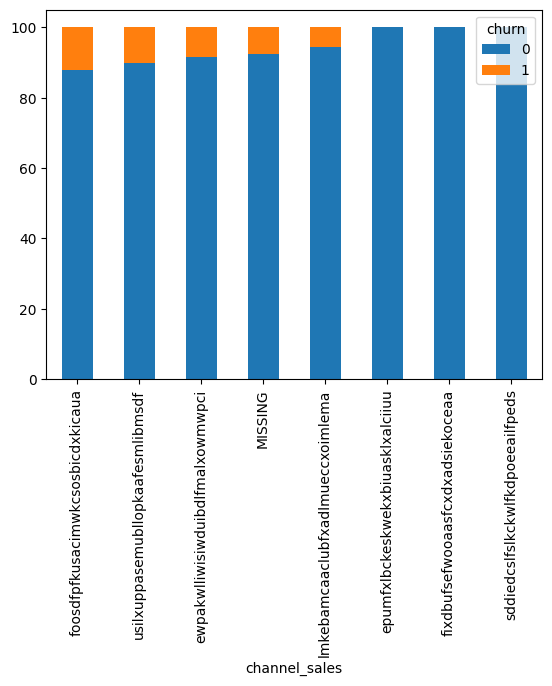

In [394]:
# Creamos un grafico de barras apiladas porcentual
channel_porc.plot(kind="bar",stacked=True)

## origin_up y churn

In [395]:
# Para un mejor entedimiento solo seleccionamos las columnas que se van a utilizar
pc1= precio_cliente[['id', 'origin_up', 'churn']]
# Pivotamos la variable "churn"
origin= pc1.groupby(["origin_up","churn"])['id'].count().unstack(level=1)
# Operamos para obtener los valores en porcentaje
origin_porc= (origin.div(origin.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)

<Axes: xlabel='origin_up'>

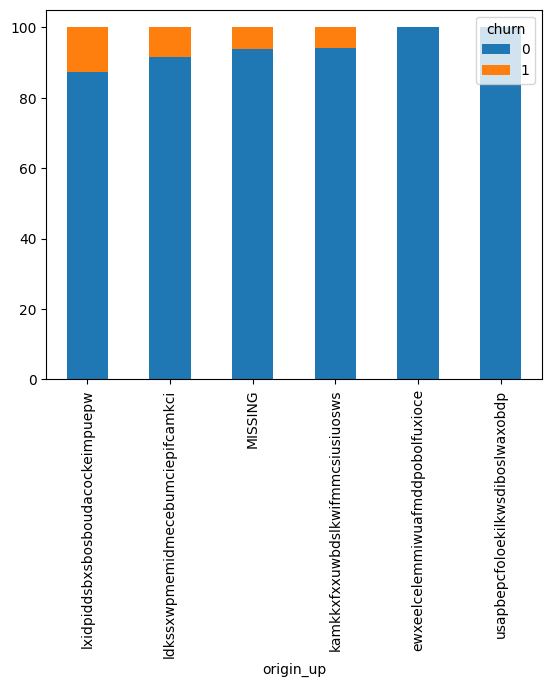

In [396]:
# Creamos un grafico de barras apiladas porcentual
origin_porc.plot(kind="bar",stacked=True)

## has_gas y churn

In [397]:
# Para un mejor entedimiento solo seleccionamos las columnas que se van a utilizar
pc2= precio_cliente[['id', 'has_gas', 'churn']]
# Pivotamos la variable "churn"
gas= pc2.groupby(["has_gas","churn"])['id'].count().unstack(level=1)
# Operamos para obtener los valores en porcentaje
gas_porc= (gas.div(gas.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)

<Axes: xlabel='has_gas'>

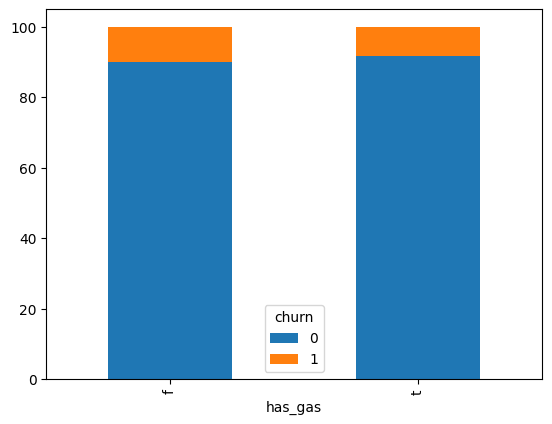

In [398]:
# Creamos un grafico de barras apiladas porcentual
gas_porc.plot(kind="bar",stacked=True)

# Transformamos a numericas

In [399]:
precio_cliente.head(1)

,id,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_mid_peak,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,...,f,40.78,43.08,43.08,1,81.42,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,17.25,0


In [400]:
# Convertir las variables categoricas a numericas
le = LabelEncoder()

precio_cliente["has_gas"] = precio_cliente["has_gas"].replace(['t', 'f'], [1, 0])
precio_cliente["channel_sales"] = le.fit_transform(precio_cliente["channel_sales"])
precio_cliente["origin_up"] = le.fit_transform(precio_cliente["origin_up"])

# Veamos las variables categoricas
precio_cliente.select_dtypes(exclude="number").columns

Index(['id', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], dtype='object')

In [401]:
# Eliminamos las variables de fecha
precio_cliente=precio_cliente.drop(["date_activ","date_end","date_modif_prod","date_renewal"], axis=1)

In [402]:
precio_cliente.to_csv("precio_cliente.csv", index=False)

In [403]:
df=pd.read_csv("/content/precio_cliente.csv")

# 2.- Dividir, preparar, entrenar y evaluar el modelo

In [404]:
X = df.drop(["churn","id"], axis=1)
y = df["churn"]

In [405]:
df.churn.value_counts()/len(df)*100

0    90.284149
1     9.715851
Name: churn, dtype: float64

In [406]:
# Nuestros datos estan desequilibrados, aplicamos la tecnica de muestreo "oversampling"

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts()

0    13186
1    13186
Name: churn, dtype: int64

In [407]:
# Divide el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [408]:
# Inicializamos el clasificador XGBoost
xgbc = XGBClassifier(random_state=42)

###############
parameter_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.09, 0.11],
    "colsample_bytree": [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "subsample": [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "min_child_weight": [1, 3, 5, 7, 9, 11, 13]
}

rscv = RandomizedSearchCV(estimator=xgbc, cv=5, param_distributions=parameter_grid, n_jobs=-1)
rscv.fit(X_train, y_train)
print("mejor parametro:",rscv.best_params_)
print("mejor puntuacion: ", rscv.best_score_)

mejor parametro: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.07, 'colsample_bytree': 0.6}
mejor puntuacion:  0.9738353914642517


In [409]:
print("accuracy on training set: ", rscv.score(X_train, y_train))
print("accuracy on test set: ", rscv.score(X_test, y_test))

accuracy on training set:  0.9992415983315164
accuracy on test set:  0.9800947867298578


In [410]:
confusion_matrix(y_test, rscv.predict(X_test))

array([[2520,  100],
       [   5, 2650]])

In [411]:
print("Accuracy: ", metrics.accuracy_score(y_test, rscv.predict(X_test)))
print("Sensitivity_recall: ", metrics.recall_score(y_test, rscv.predict(X_test)))
print("Precision: ", metrics.precision_score(y_test, rscv.predict(X_test)))
print("F1_score: ", metrics.f1_score(y_test, rscv.predict(X_test)))

Accuracy:  0.9800947867298578
Sensitivity_recall:  0.9981167608286252
Precision:  0.9636363636363636
F1_score:  0.9805735430157262


In [412]:
# Observamos las clases ppredichas y sus probabilidades para cada clase respectivamente
df_predictions = pd.DataFrame({"churn": y_test,
              "churn_predicted": rscv.predict(X_test),
              "predicted_proba_0": rscv.predict_proba(X_test)[:, 0],
              "predicted_proba_1": rscv.predict_proba(X_test)[:, 1]
             })
df_predictions.sample(10)

,churn,churn_predicted,predicted_proba_0,predicted_proba_1
23454,1,1,0.039019,0.960981
2081,0,0,0.575342,0.424658
4469,0,0,0.857772,0.142228
22007,1,1,0.032932,0.967068
139,1,1,0.347563,0.652437
22501,1,1,0.042871,0.957129
6433,0,0,0.584098,0.415902
19594,1,1,0.038086,0.961914
3581,0,0,0.729650,0.270350
8148,0,0,0.956163,0.043837


In [413]:
# Por default las probabilidades predichas de las clases es mayor igual a "0.5" subiremos a...
# "0.7" la probabilidad predicha de la clase 0 (no fugan)
df_predictions["churn_predicted_adjusted"] = [0 if x > 0.7 else 1 for x in df_predictions["predicted_proba_0"]]
df_predictions.sample(5)

,churn,churn_predicted,predicted_proba_0,predicted_proba_1,churn_predicted_adjusted
15969,1,1,0.041346,0.958654,1
3068,0,0,0.756269,0.243731,0
6280,0,0,0.980938,0.019062,0
7136,0,0,0.961490,0.038510,0
23026,1,1,0.123763,0.876237,1


In [414]:
print("churn:\n",df_predictions["churn"].value_counts())
print("\nchurn_predicted:\n",df_predictions["churn_predicted"].value_counts())
print("\nchurn_predicted_adjusted:\n",df_predictions["churn_predicted_adjusted"].value_counts())

churn:
 1    2655
0    2620
Name: churn, dtype: int64

churn_predicted:
 1    2750
0    2525
Name: churn_predicted, dtype: int64

churn_predicted_adjusted:
 1    2964
0    2311
Name: churn_predicted_adjusted, dtype: int64


In [415]:
# Observamos la importancia de las caracteristicas
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': rscv.best_estimator_.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index()
feature_importances

,index,features,importance
0,22,mean_3m_price_peak_fix,0.041173
1,51,origin_up,0.034634
2,47,margin_net_pow_ele,0.029030
3,25,mean_3m_price_peak,0.024102
4,39,forecast_discount_energy,0.023375
5,26,mean_3m_price_mid_peak,0.021941
6,24,mean_3m_price_off_peak,0.021617
7,8,mean_year_price_mid_peak,0.021381
8,46,margin_gross_pow_ele,0.021070
9,34,cons_12m,0.020965


In [416]:
session_info.show(html=False)

-----
imblearn            0.10.1
matplotlib          3.7.1
pandas              1.5.3
seaborn             0.12.2
session_info        1.0.0
sklearn             1.2.2
xgboost             2.0.2
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.5.0
notebook            6.5.5
-----
Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Linux-5.15.120+-x86_64-with-glibc2.35
-----
Session information updated at 2023-12-04 16:44
